In [1]:
#libs for setup training set
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
from tempfile import TemporaryFile

#libs for Bayes deciding
from math import log

In [2]:
'''
Function: normalize the input list
@param arr: input list
@return arr: output list
'''
def normalize(arr):
    #get the summation of all elements
    sum = 0
    for i in range(len(arr)):
        sum = sum + arr[i]
        
    #iteratively normalize
    #make whole arr sum to 100
    for i in range(len(arr)):
        arr[i] = arr[i]/sum * 100   
    return arr


'''
Function: get steady state a time-domain signal
@param sig: input time-domain signal
@return sts_sig: the stead-state part of the input
'''
def getSteadyState(sig):
    #first get the amplitude of the signal
    all_sig = sig * sig
    #first get the average amplitude
    avg = sum(all_sig)/len(all_sig)
    #find the part below avgerage from the back
    rev_sig = all_sig[::-1]
    back_idx = 0
    for i in range(0,len(rev_sig)):
        if rev_sig[i] > avg:
            back_idx = i
            break
    back_idx = len(rev_sig) - back_idx
    #find the part below avgerage from the front
    front_idx = 0
    for i in range(0,len(all_sig)):
        if all_sig[i] > avg:
            front_idx = i
            break
   
    #get the steady-state signal
    sts_sig = sig[front_idx : back_idx]
#     print("sts's length: ", sts_sig.shape, "original's length ",sig.shape)
    
    return sts_sig

In [3]:
#get the current workspace's abs path
path = os.getcwd()
print("workspace: " + path)
#get the file names of instrument sounds
snds_path = os.listdir(path + '/instru_snds')
traits_path = os.listdir(path + '/traits')

#get the types of instruments
for file in snds_path:
    if file.startswith("labels"):
        print("loading in: " + file)
        types = []
        f = open('instru_snds/' + file, "r")
        for x in f:
            if x.endswith('\n'):
                types.append(x.rstrip('\n'))
            else:
                types.append(x)
f.close()
print("types include", types)
print("loading completed")

#get energy traits for each instrument
#get which categories exist
cats = []
for file in snds_path:
    if file.startswith("categories"):
        print("loading in: " + file)
        f = open('instru_snds/' + file, "r")
        for x in f:
            if x.endswith('\n'):
                cats.append(x.rstrip('\n'))
            else:
                cats.append(x)
f.close()
print("categories include", cats)
#get the relationship between each type and the corresponding category
each_cat = []
for file in snds_path:
    if file.startswith("each_category"):
        print("loading in: " + file)
        f = open('instru_snds/' + file, "r")
        for x in f:
            if x.endswith('\n'):
                each_cat.append(x.rstrip('\n'))
            else:
                each_cat.append(x)
f.close()
#get the energy trait for each category
ene_traits = [[] for i in range(len(cats))]
for file in traits_path:
    if file.endswith(".wav"):
        #find which type it is
        for i in range (len(types)):
            if file.startswith(types[i]):
                print("categorizing: " + file)
                audio = np.array([])
                fs,audio = wavfile.read('traits/' + file) #load the data
                if audio.ndim > 1:
                    audio = audio[:,0] 
                var = np.var(audio)
                for j in range(len(cats)):
                    if cats[j] == each_cat[i]:
                        ene_traits[j].append(var)
                        print(file + " has var ", var)
#calc averages
np.asarray(ene_traits)
ene_traits_num = np.zeros(len(ene_traits))
for i in range(len(ene_traits)):
    ene_traits_num[i] = np.mean(ene_traits[i])
    print(cats[i], "has trait", ene_traits_num[i])
print("get energy traits completed")


#get all time-domain signals
#initialize the 2-D array
all_snds = [[] for i in range(len(types))]
all_fs = []
for file in snds_path:
    if file.endswith(".wav"):
        #find which type it is
        for i in range (len(types)):
            if file.startswith(types[i]):
                print("loading in: " + file)
                audio = np.array([])
                fs,audio = wavfile.read('instru_snds/' + file) #load the data
                snds = all_snds[i]
                snds.append(audio)
                all_fs.append(fs)


#get the steady-states of snds
for i in range(0,len(all_snds)):
    for j in range(0, len(all_snds[i])):
        if all_snds[i][j].ndim > 1:
            all_snds[i][j] = all_snds[i][j][:,0]        
        all_snds[i][j] = getSteadyState(all_snds[i][j])
        all_snds[i][j] = np.asarray(all_snds[i][j])
all_fs = np.asarray(all_fs)


#FFT
print("start FFT")
#initialize the 2-D array
all_FFTs = [[[]for i in range(len(all_snds[j]))] for j in range(len(types))]

for i in range(len(types)):
    for j in range(len(all_snds[i])):
        audio = all_snds[i][j]
        AUD = np.fft.rfft(audio,1000)
        AUD = np.absolute(AUD)
        AUD = normalize(AUD)
        all_FFTs[i][j] = AUD
        
        plt.figure()
        plt.plot(all_FFTs[i][j])
        plt.title("type-" + types[i] + str(j))
                  
print("FFT completed")


#flatten the array for next step(preferably not)
labels = []
all_FFTs_flat = []
for i in range(len(types)):
    for j in range(len(all_FFTs[i])):
        all_FFTs_flat.append(all_FFTs[i][j])
        labels.append(types[i])

labels = np.asarray(labels)
all_FFTs_flat = np.asarray(all_FFTs_flat)
        
#output the array
np.save("labels.npy", labels)
np.save("train_set", all_FFTs_flat)

workspace: /mnt/c/Users/24488/Desktop/Study/In_reg/ece397_project
loading in: labels.txt
types include ['rfl', 'Piano', 'Guitar']
loading completed
loading in: categories.txt
categories include ['string', 'wind']
loading in: each_category.txt
categorizing: Guitar_test2.wav
Guitar_test2.wav has var  2544015.951106868
categorizing: Guitar_test6.wav
Guitar_test6.wav has var  6571823.195365634
categorizing: Guitar_test7.wav
Guitar_test7.wav has var  3185738.3222631207
categorizing: Guitar_test8.wav
Guitar_test8.wav has var  4970524.146888647
categorizing: Piano_test5.wav
Piano_test5.wav has var  4701240.581330483
categorizing: Piano_test6.wav
Piano_test6.wav has var  4056258.326844666
categorizing: rfl_test3.wav
rfl_test3.wav has var  3061535.6274825116
categorizing: rfl_test4.wav
rfl_test4.wav has var  3058176.877155537
categorizing: rfl_test5.wav
rfl_test5.wav has var  3054331.3550793454
string has trait 4338266.75396657
wind has trait 3058014.6199057978
get energy traits completed
loadi

In [4]:
#test if have the correct npy file
#print the labels
load_labels = np.load("labels.npy")
load_set = np.load("train_set.npy")

print(load_labels)
# for i in range(len(load_set)):
    # plt.figure()
    # plt.plot(load_set[i])
    # plt.title("type--"+ load_labels[i])

['rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl'
 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl'
 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl'
 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl' 'rfl'
 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano'
 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano'
 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano'
 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano'
 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano' 'Piano'
 'Piano' 'Piano' 'Piano' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar'
 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar'
 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar'
 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar'
 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar' 'Guitar'

In [5]:
#set up input
'''
Function: setup the input signal to return its FFT arrays
@param input: input audio array
@param fs: the sampling rate of the input signal
@return input_FFTs: output array of FFTs
'''
def setupInput(input,fs):
    #first get the absolute time duration of the input
#     input = getSteadyState(input)
    input_FFTs = []
    tru = 1
    print("input size ", input.shape)
    
    #cut the signal into pieces of 2 seconds
    i = 0
    if len(input)/fs < 2:
        in_piece = input
        in_piece = getSteadyState(in_piece)
        AUD = np.fft.rfft(in_piece,1000)
        AUD = np.absolute(AUD)
        AUD = normalize(AUD)
        input_FFTs.append(AUD)
        
    else:
        i = 0
        while (i+tru)*fs < len(input):
            i_b = int(i*fs)
            i_n = int((i+tru)*fs)
#             print(i_b, i_n)
            in_piece = input[i_b:i_n]
#             print("in_piece", in_piece.shape)
            in_piece = getSteadyState(in_piece)
            AUD = np.fft.rfft(in_piece,1000)
            AUD = np.absolute(AUD)
            AUD = normalize(AUD)
            input_FFTs.append(AUD)
            i = i+tru
    return input_FFTs

In [6]:
import numpy as np

def harmonic_in_instrument(harmonic, instrument_spec):
    threshold = 11 #10.5 current best       # this constant requires further modification
#     print(type(harmonic))
#     print(len(harmonic))
    for spec in instrument_spec:
#         print(type(np.asarray(spec)))
#         print(len(spec))
#         print(instrument_spec.index(spec))
        if np.linalg.norm(np.asarray(spec) - harmonic) < threshold:
            return instrument_spec.index(spec) + 1
    return 0

In [7]:
# naive_bayes.py
# ---------------
# Licensing Information:  You are free to use or extend this projects for
# educational purposes provided that (1) you do not distribute or publish
# solutions, (2) you retain this notice, and (3) you provide clear
# attribution to the University of Illinois at Urbana-Champaign
#
# Created by Justin Lizama (jlizama2@illinois.edu) on 09/28/2018

"""
This is the main entry point for MP4. You should only modify code
within this file -- the unrevised staff files will be used for all other
files and classes when code is run, so be careful to not modify anything else.
"""
# import nltk
import numpy as np
from math import log

def naiveBayes(train_set, train_labels, dev_set, test_sig):
    """
    train_set - List of list of words corresponding with each movie review
    example: suppose I had two reviews 'like this movie' and 'i fall asleep' in my training set
    Then train_set := [['like','this','movie'], ['i','fall','asleep']]

    train_labels - List of labels (instruments) corresponding with train_set
    example: Suppose I had two reviews, first one was positive and second one was negative.
    Then train_labels := [1, 0]

    dev_set - List of list of words corresponding with each review that we are testing on
              It follows the same format as train_set

    smoothing_parameter - The smoothing parameter you provided with --laplace (1.0 by default)
    """
    # TODO: Write your code here
    # return predicted labels of development set
#     smoothing_parameter = 0.0000001
    smoothing_parameter = 0.0001
    instrument1_spec = list()   # clarinet
    instrument1_occur = list()
    instrument2_spec = list()   # bassoon
    instrument2_occur = list()
    instrument3_spec = list()   # flute
    instrument3_occur = list()


    
#     instrument4 = dict()
#     instrument5 = dict()
    log_instrument1 = log(1./3.) + 10   #FLUTE
    log_instrument2 = log(1./3.)   #PIANO
    log_instrument3 = log(1./3.)   #GUITAR
    
    if test_sig.ndim > 1:
        test_sig = test_sig[:,0]
    var_input = np.var(test_sig)
    print("var is ", var_input)
    
    if var_input > 3500000:
        log_instrument1 = log(1./3.)
        log_instrument2 = log(1./3.) + 20
        log_instrument3 = log(1./3.) + 20

    for i in range(len(train_set)):
        if train_labels[i] == "rfl":       # the first instrument name. 某一个音有哪些harmonic 和 harmonic number
                                        # dict{(array of amplitudes):string (tone of an instrument)}
#             for harmonics in train_set[i]:
#             print(train_set[i])
#             print(instrument1_spec)
            if train_set[i].tolist() in instrument1_spec:             #if harmonics in instrument1:
                instrument1_occur[instrument1_spec.index(train_set[i].tolist())] += 1          #train_set[i] <---> harmonics
            else:
                instrument1_spec.append(train_set[i].tolist())
                instrument1_occur.append(1)
                    
        elif train_labels[i] == "Piano":
#             for harmonics in train_set[i]:
            if train_set[i].tolist() in instrument2_spec:
                instrument2_occur[instrument2_spec.index(train_set[i].tolist())] += 1
            else:
                instrument2_spec.append([train_set[i].tolist()])
                instrument2_occur.append(1)

        else: # Guitar
            if train_set[i].tolist() in instrument3_spec:
                instrument3_occur[instrument3_spec.index(train_set[i].tolist())] += 1
            else:
                instrument3_spec.append(train_set[i].tolist())
                instrument3_occur.append(1)


    instrument1_occur[-1] = 0
    instrument2_occur[-1] = 0
    instrument3_occur[-1] = 0

    for occurence in range(0, len(instrument1_occur)):
        instrument1_occur[occurence] += smoothing_parameter

    for occurence in range(0, len(instrument2_occur)):
        instrument2_occur[occurence] += smoothing_parameter

    for occurence in range(0, len(instrument3_occur)):
        instrument3_occur[occurence] += smoothing_parameter
        
    Sum1 = sum(instrument1_occur)
    Sum2 = sum(instrument2_occur)
    Sum3 = sum(instrument3_occur)

#     probability_1 = dict()
#     probability_2 = dict()
#     probability_3 = dict()

    for harmonics in range(0, len(instrument1_occur)):
        instrument1_occur[harmonics] = instrument1_occur[harmonics]/Sum1
    for harmonics in range(0, len(instrument2_occur)):
        instrument2_occur[harmonics] = instrument2_occur[harmonics]/Sum2
    for harmonics in range(0, len(instrument3_occur)):
        instrument3_occur[harmonics] = instrument3_occur[harmonics]/Sum3
   
    ret = list()
#     print(dev_set)
    
#     for i in range(len(dev_set)):
    

    for harmonic in dev_set:
        index1 = harmonic_in_instrument(harmonic.tolist(), instrument1_spec)
#                 print(harmonic.tolist())
        if index1:
            log_instrument1 += log(instrument1_occur[index1-1])
        else:
            log_instrument1 += log(instrument1_occur[-1])

        index2 = harmonic_in_instrument(harmonic.tolist(), instrument2_spec)
        if index2:
            log_instrument2 += log(instrument2_occur[index2-1])
#             log_instrument2 += log(0.3)
        else:
            log_instrument2 += log(instrument2_occur[-1])

        index3 = harmonic_in_instrument(harmonic.tolist(), instrument3_spec)
        if index3:
            log_instrument3 += log(instrument3_occur[index3-1])
#              log_instrument3 += log(0.3)
        else:
            log_instrument3 += log(instrument3_occur[-1])

    log_max = max(log_instrument1, log_instrument2, log_instrument3)
    print("prob_flute = ", log_instrument1)
    print("prob_piano = ", log_instrument2)
    print("prob_guitar = ", log_instrument3)


    if log_max == log_instrument1:
        ret.append("flute")

    elif log_max == log_instrument2:
        ret.append("piano")

    elif log_max == log_instrument3:
        ret.append("guitar")

#         if log_instrument1 > log_instrument2:
#             if log_instrument3 > log_instrument1:
#                 ret.append(2)
#             else:

#         else:
#             ret.append(0)
    return ret

In [9]:
import sys
import argparse
import configparser
import copy
import numpy as np

# import reader
# import naive_bayes as nb

"""
This file contains the main application that is run for this MP.
"""

def compute_accuracies(predicted_labels, dev_set, dev_labels):
    yhats = predicted_labels
    accuracy = np.mean(yhats == dev_labels)
    tp = np.sum([yhats[i] == dev_labels[i] and yhats[i] == 1 for i in range(len(yhats))])
    precision = tp / np.sum([yhats[i] == 1 for i in range(len(yhats))])
    recall = tp / (np.sum([yhats[i] != dev_labels[i] and yhats[i] == 0 for i in range(len(yhats))]) + tp)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, f1, precision, recall


def main():
    print("start test")
    train_set = np.load("train_set.npy")
    train_labels = np.load("labels.npy")

    p_c_ct = 0
    f_c_ct = 0
    g_c_ct = 0
    correct_ct = 0
    p_ct = 0
    f_ct = 0
    g_ct = 0
    ct = 0
    tests_path = os.listdir(path + '/tests')
    for test in tests_path:
        if test.endswith(".wav"):
            ct+=1
            fs,test_sig = wavfile.read('tests/' + test) #load the data
            if test_sig.ndim > 1:
                test_sig = test_sig[:,0]            
            test_FFT = setupInput(test_sig,fs)
            print("read " + test + "==========================")
#             print("start testing")    
            predicted_labels = naiveBayes(train_set, train_labels, test_FFT, test_sig)
            print(predicted_labels)
#             print("end testing")
            truth = []
            if test.startswith("Piano"):
                truth.append("piano")
            elif test.startswith("Guitar"):
                truth.append("guitar")
            elif test.startswith("flute"):
                truth.append("flute")
            print("decided: ", predicted_labels, " truth is: ", truth)
            if truth == predicted_labels:
                print("correct+++++++++++++++++++++++++++++")
                correct_ct+=1
                if test.startswith("Piano"):
                    p_ct+=1
                    p_c_ct+=1
                elif test.startswith("Guitar"):
                    g_ct+=1
                    g_c_ct+=1
                elif test.startswith("flute"):
                    f_ct+=1
                    f_c_ct+=1
            else:
                print("not so much-------------------------------")
                if test.startswith("Piano"):
                    p_ct+=1
                elif test.startswith("Guitar"):
                    g_ct+=1
                elif test.startswith("flute"):
                    f_ct+=1
    
    print("piano correction rate = ",p_c_ct/p_ct*100,"%")
    print("guitar correction rate = ",g_c_ct/g_ct*100,"%")
    print("flute correction rate = ",f_c_ct/f_ct*100,"%")
    print("correction rate = ",correct_ct/ct*100,"%")


main()
    



start test
input size  (2402430,)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
read flute_test1.wav==========================
var is  3053785.419454156
prob_flute =  -598.0747451533841
prob_piano =  -654.128117095225
prob_guitar =  -589.6549281541618
['guitar']
decided:  ['guitar']  truth is:  ['flute']
not so much-------------------------------
input size  (1783296,)
read flute_test10.wav==========================
var is  3061941.871669608
prob_flute =  -476.67951858044097
prob_piano =  -523.5222161339136
prob_guitar =  -486.6803695682255
['flute']
decided:  ['flute']  truth is:  ['flute']
correct+++++++++++++++++++++++++++++
input size  (1217516,)
read flute_test2.wav==========================
var is  3050341.6804008656
prob_flute =  -278.2862031824751
prob_piano =  -327.6133646919466
prob_guitar =  -318.4028711388561
['flute']
decided:  ['flute']  truth is:  ['flute']
cor

loading in: Guitar_test8.wav
loading in: flute_test3.wav
loading in: flute_test2.wav
loading in: flute_test1.wav
loading in: Piano_test6.wav
loading in: Piano_test7.wav
loading in: Piano_test5.wav
loading in: Guitar_test1.wav
loading in: Guitar_test3.wav


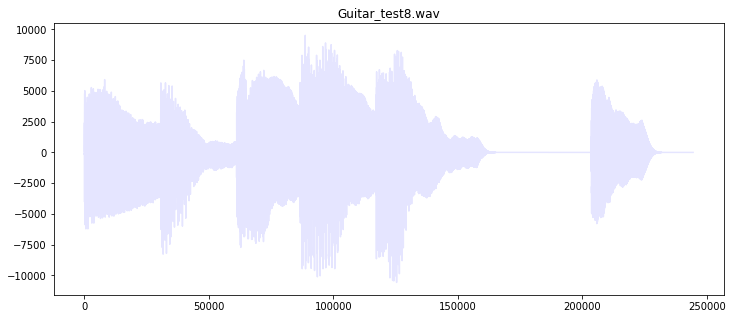

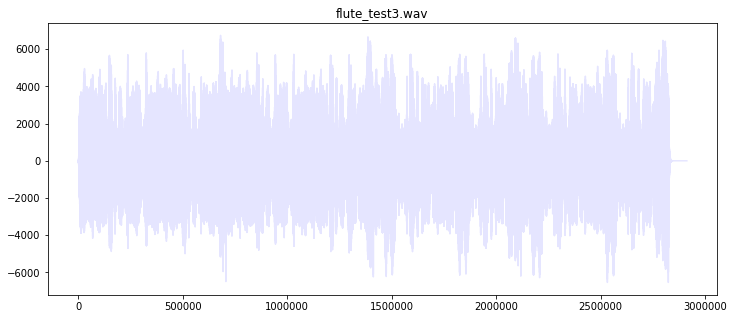

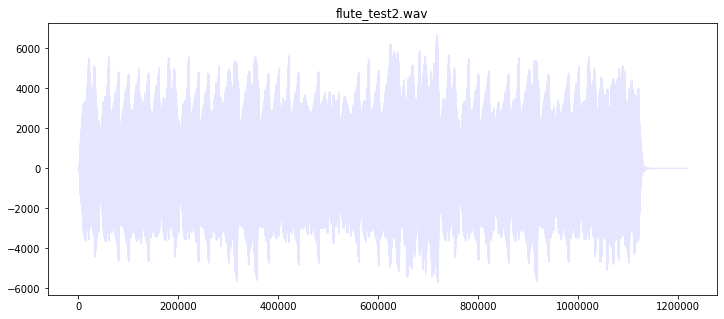

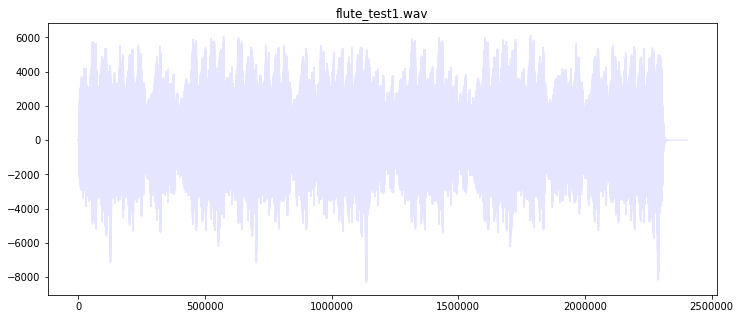

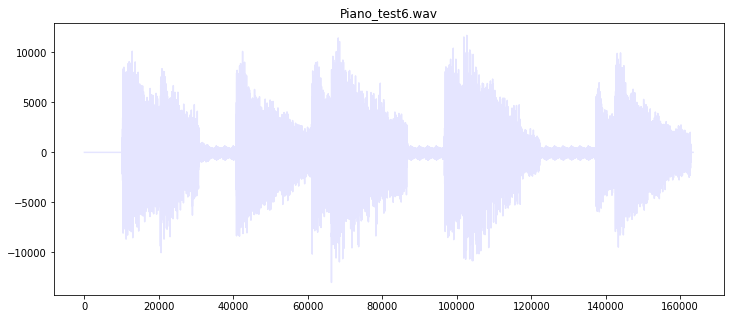

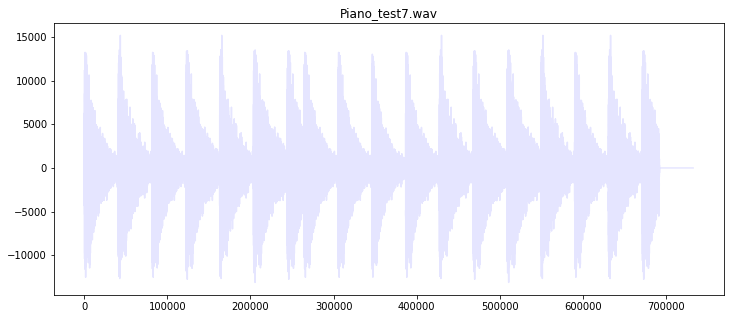

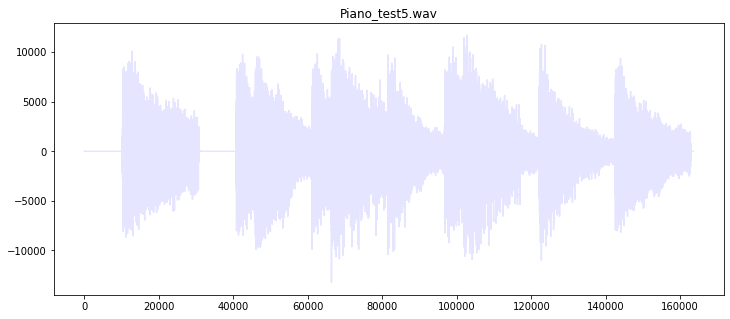

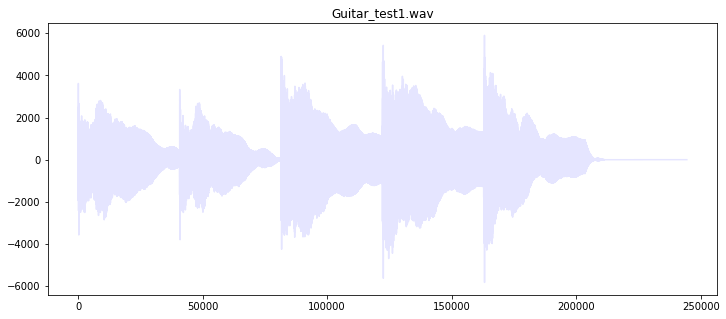

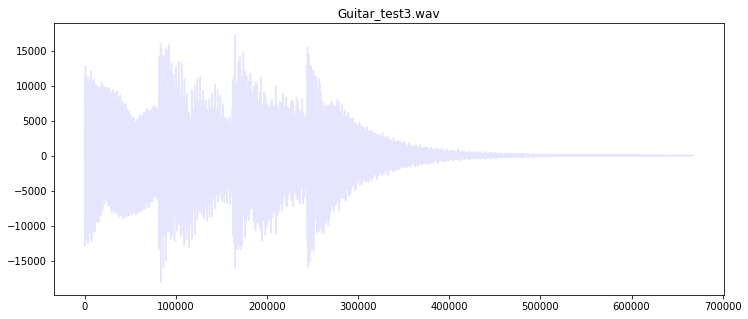

In [443]:
#time-domain
aud_path = os.listdir(path + '/audios')
for file in aud_path:
    print("loading in: " + file)
    audio = np.array([])
    fs,audio = wavfile.read('audios/' + file) #load the data
    audio = audio[:,0]
    plt.figure(figsize=(12,5))
    plt.plot(audio,"b", alpha = 0.1)
    plt.title(file)
